In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from sleeprnn.data import utils
from sleeprnn.common import viz

viz.notebook_full_width()

In [ ]:
# obtained through first order taylor expansion equality between gaussian and hann windows
sigma_truncation = np.sqrt(2) * np.pi / 2
print(sigma_truncation)

# Cycles in gaussian window similar to hann window

In [ ]:
fs = 10
max_t = 5
sigma_truncation = 2.2214  # obtained through first order taylor expansion equality between gaussian and hann windows
t = np.arange(-max_t*fs, max_t*fs + 0.001) / fs
window_gauss = np.exp(-(t ** 2) / 2)
effective_size = 2 * (np.sum(np.abs(t) <= sigma_truncation) // 2) + 1
window_hann = np.hanning(effective_size)
t_hann = np.arange(effective_size) / fs
t_hann = t_hann - t_hann.mean()

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.plot(t, window_gauss, label="gaussian")
ax.plot(t_hann, window_hann, label="hann at truncation %s" % sigma_truncation)
ax.axvline(-sigma_truncation, color="k", linestyle="--")
ax.axvline(sigma_truncation, color="k", linestyle="--")
ax.legend()
ax.set_ylim([0, None])
plt.show()

# CMorlet wavelet with expansion factor

In [ ]:
def adjust_scale(scale, q, max_scale):
    return scale * q + max_scale * (1.0 - q)


def beta_for_cycles_at_frequency(n_cycles, frec, q, min_freq, sigma_truncation=3):
    scale = 1 / frec
    adjusted_scale = adjust_scale(scale, q, 1/min_freq)
    adjustment_term = (adjusted_scale / scale) ** 2
    truncation_term = 2 * (sigma_truncation ** 2)
    beta = (n_cycles ** 2 / truncation_term) / adjustment_term
    return beta


def generate_wavelets(
    min_freq,
    max_freq,
    n_scales,
    beta,
    q=1.0,
    fs=200,
    size_factor=1.0,
):
    s_0 = 1.0 / max_freq
    s_n = 1.0 / min_freq
    base = np.power(s_n / s_0, 1.0 / (n_scales - 1.0))
    scales = s_0 * np.power(base, np.arange(n_scales))
    scales = scales.astype(np.float32)
    scales = np.flip(scales) # So that frequencies are in increasing order
    adjusted_scales = adjust_scale(scales, q, s_n)
    # Frequencies
    frequencies = 1 / scales
    # Time axis
    one_side = int(size_factor * np.max(adjusted_scales) * fs * np.sqrt(4.5 * beta))
    kernel_size = 2 * one_side + 1
    k_array = np.arange(kernel_size, dtype=np.float32) - one_side
    k_array = k_array / fs  # Time units
    # Wavelet bank shape: 1, kernel_size, 1, n_scales
    wavelet_bank_real = []
    wavelet_bank_imag = []
    for i in range(n_scales):
        norm_constant = np.sqrt(np.pi * beta) * adjusted_scales[i] * fs / 2.0
        exp_term = np.exp(-((k_array / adjusted_scales[i]) ** 2) / beta)
        kernel_window = exp_term / norm_constant
        kernel_real = kernel_window * np.cos(2 * np.pi * k_array / scales[i])
        kernel_imag = kernel_window * np.sin(2 * np.pi * k_array / scales[i])
        wavelet_bank_real.append(kernel_real)
        wavelet_bank_imag.append(kernel_imag)
    # Stack wavelets (shape = kernel_size, n_scales)
    wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
    wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)
    return wavelet_bank_real, wavelet_bank_imag, frequencies

In [ ]:
min_freq = 0.5
q = 0.9
frec = 13
sigma_truncation_for_cycles = 2.2214
print("Expansion factor %1.2f, min freq %s Hz, and truncating at %s sigmas of gaussian window to count cycles" % (q, min_freq, sigma_truncation_for_cycles))
for n_cycles in [2, 3, 4, 5, 6, 7]:
    beta = beta_for_cycles_at_frequency(n_cycles, frec, q, min_freq, sigma_truncation=sigma_truncation_for_cycles)
    print("Use beta %1.4f to have %s cycles at %s Hz" % (beta, n_cycles, frec))

In [ ]:
beta = 0.0331
n_scales = 5
min_freq = 0.5
max_freq = 13
q_list = [0, 0.9, 1]

print("Beta %s" % beta)
fig, ax = plt.subplots(n_scales, len(q_list), sharex=True, dpi=100, figsize=(16, 6))
for i, q in enumerate(q_list):
    w_real, w_imag, freqs = generate_wavelets(min_freq, max_freq, n_scales, beta, q)
    print("Kernel size", w_real.shape[0])
    for j in range(n_scales):
        ax[j, i].plot(w_real[:, j], linewidth=0.6)
        # ax[j, i].plot(w_imag[:, j], linewidth=0.6)
        ax[j, i].set_title("%1.2f Hz (q = %s)" % (freqs[j], q))
plt.tight_layout()
plt.show()


# Pink noise
Implemented at https://github.com/felixpatzelt/colorednoise/blob/master/colorednoise.py

In [2]:
from numpy import sqrt, newaxis
from numpy.fft import irfft, rfftfreq
from numpy.random import normal
from numpy import sum as npsum
from scipy.signal import firwin


def powerlaw_psd_gaussian(exponent, size, fmin=0):
    """Gaussian (1/f)**beta noise.
    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)
    Normalised to unit variance
    Parameters:
    -----------
    exponent : float
        The power-spectrum of the generated noise is proportional to
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    try:
        size = list(size)
    except TypeError:
        size = [size]
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples)
    
    # Build scaling factors for all frequencies
    s_scale = f
    fmin = max(fmin, 1./samples) # Low frequency cutoff
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # Generate scaled random power + phase
    sr = normal(scale=s_scale, size=size)
    si = normal(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2): si[...,-1] = 0
    
    # Regardless of signal length, the DC component must be real
    si[...,0] = 0
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y


def apply_lowpass(signal, fs, cutoff, filter_duration_ref=6, wave_expansion_factor=0.5):
    numtaps = fs * filter_duration_ref / (cutoff ** wave_expansion_factor)
    numtaps = int(2 * (numtaps // 2) + 1)  # ensure odd numtaps
    lp_kernel = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
    lp_kernel /= lp_kernel.sum()
    new_signal = utils.filter_fir(lp_kernel, signal)
    return new_signal


def apply_highpass(signal, fs, cutoff, filter_duration_ref=6, wave_expansion_factor=0.5):
    numtaps = fs * filter_duration_ref / (cutoff ** wave_expansion_factor)
    numtaps = int(2 * (numtaps // 2) + 1)  # ensure odd numtaps
    lp_kernel = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
    lp_kernel /= lp_kernel.sum()
    # HP = delta - LP
    hp_kernel = -lp_kernel
    hp_kernel[numtaps//2] += 1
    new_signal = utils.filter_fir(hp_kernel, signal)
    return new_signal


def apply_bandpass(signal, fs, lowcut, highcut, filter_duration_ref=6, wave_expansion_factor=0.5):
    new_signal = signal
    if lowcut is not None:
        new_signal = apply_highpass(
            new_signal, fs, lowcut, filter_duration_ref, wave_expansion_factor)
    if highcut is not None:
        new_signal = apply_lowpass(
            new_signal, fs, highcut, filter_duration_ref, wave_expansion_factor)
    return new_signal

In [14]:
def approximate_powerlaw_gaussian(
    n_series,
    n_samples,
    fs,
    exponent=1, 
    f_min=1,
    f_max=31,
    width=2,
):
    """@Author: Nicolas I. Tapia-Rivas"""
    # Last axis is number of examples
    bands_init = np.arange(f_min, f_max, width)
    bands_end = np.clip(bands_init + width, a_min=None, a_max=f_max)
    frequencies = np.stack([bands_init, bands_end], axis=1).mean(axis=1)
    scales = 1 / (frequencies ** exponent)
    scales = scales / scales.min()
    cutoff_list = np.unique(np.concatenate([bands_init, bands_end]))
    # To crop borders
    start_sample = n_samples // 2
    end_sample = start_sample + n_samples

    bands_list = []
    y_base = np.random.normal(size=(n_series, 2 * n_samples))
    for f_low in cutoff_list:
        y_band = apply_lowpass(y_base, fs, f_low)  # (past_f_low, f_low)
        y_base = y_base - y_band  # [f_low, fs/2]
        y_band = y_band[:, start_sample:end_sample]  # [n_series, n_samples]
        # Normalize band
        mean = y_band.mean(axis=1, keepdims=True)  # [n_series, 1]
        std = y_band.std(axis=1, keepdims=True)  # [n_series, 1]
        y_band = (y_band - mean) / std  # [n_series, n_samples]
        bands_list.append(y_band)
    bands_list = bands_list[1:]  # Ignore band [0, f_min]
    bands_list = np.stack(bands_list, axis=2)  # [n_series, n_samples, n_bands]
    random_signal = np.dot(bands_list, scales)  # [n_series, n_samples]
    # Normalize result
    mean = random_signal.mean(axis=1, keepdims=True) # [n_series, 1]
    std = random_signal.std(axis=1, keepdims=True) # [n_series, 1]
    random_signal = (random_signal - mean) / std  # [n_series, n_samples]
    return random_signal

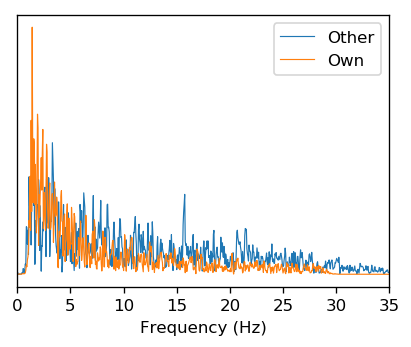

Other std: 19.209160999999998
Own std: 19.209160999999998


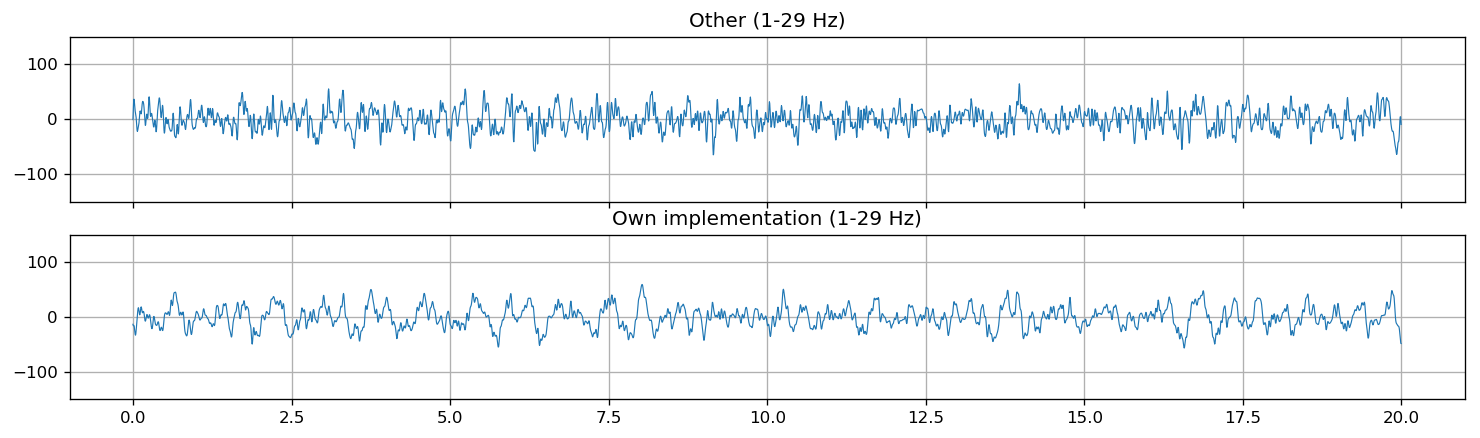

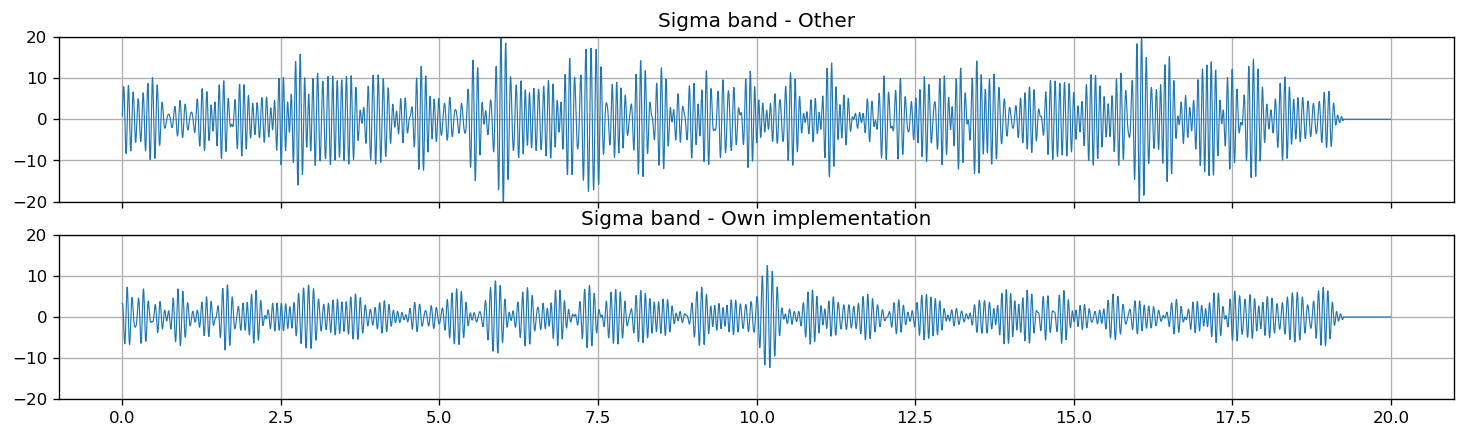

In [63]:
fs = 200
window = 20
beta = 1.14 # the exponent
samples = fs * window
f_min = 1
f_max = 29
signal_std = 19.209161  # CapFullSS std is 19.209161 (only NREM sleep stages)  
# <- it should copy the signal std of MASS-Train N2 stage only in [f_min, f_max] Hz only.


t = np.arange(samples) / fs

# Implementation from internet
y = powerlaw_psd_gaussian(beta, samples)
y = utils.broad_filter(y, fs, lowcut=f_min, highcut=f_max)
y = (y - y.mean()) / y.std()
y = y * signal_std

# Own implementation
y_own = approximate_powerlaw_gaussian(1, samples, fs, exponent=beta, f_min=f_min, f_max=f_max) # already normalized
y_own = y_own[0] * signal_std

# Comparison of power spectrum
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
for signal, label in zip([y, y_own], ['Other', 'Own']):
    power, freq = utils.power_spectrum(signal, fs, apply_hanning=True)
    ax.plot(freq, power, linewidth=0.7, label=label)
ax.legend()
ax.set_xlim([0, 35])
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
plt.show()

# Comparison of generated signal
print("Other std:", y.std())
print("Own std:", y_own.std())
fig, ax = plt.subplots(2, 1, figsize=(15, 4), dpi=120, sharex=True, sharey=True)
ax[0].plot(t, y, linewidth=0.7)
ax[0].set_title("Other (%d-%d Hz)" % (f_min, f_max))
ax[1].set_title("Own implementation (%d-%d Hz)" % (f_min, f_max))
ax[1].plot(t, y_own, linewidth=0.7)
ax[1].set_ylim([-150, 150])
ax[1].grid()
ax[0].grid()
plt.show()

# Comparison of Sigma band
fig, ax = plt.subplots(2, 1, figsize=(15, 4), dpi=120, sharex=True, sharey=True)
ax[0].plot(t, apply_bandpass(y, fs, 11, 16), linewidth=0.7)
ax[0].set_title("Sigma band - Other")
ax[1].set_title("Sigma band - Own implementation")
ax[1].plot(t, apply_bandpass(y_own, fs, 11, 16), linewidth=0.7)
ax[1].set_ylim([-20, 20])
ax[1].grid()
ax[0].grid()
plt.show()

In [64]:
# Mean spectrum
n_windows = 100

# Other
tmp = []
for i in range(n_windows):
    y = powerlaw_psd_gaussian(beta, samples)
    y = utils.broad_filter(y, fs, lowcut=f_min, highcut=f_max)
    y = (y - y.mean()) / y.std()
    y = y * signal_std
    power, freq = utils.power_spectrum(y, fs, apply_hanning=True)
    tmp.append(power)
mean_power = np.stack(tmp, axis=1).mean(axis=1)

# Own implementation
y = approximate_powerlaw_gaussian(n_windows, samples, fs, exponent=beta, f_min=f_min, f_max=f_max)
y = y * signal_std
tmp = []
for i in range(n_windows):
    power, freq = utils.power_spectrum(y[i], fs, apply_hanning=True)
    tmp.append(power)
mean_power_own = np.stack(tmp, axis=1).mean(axis=1)

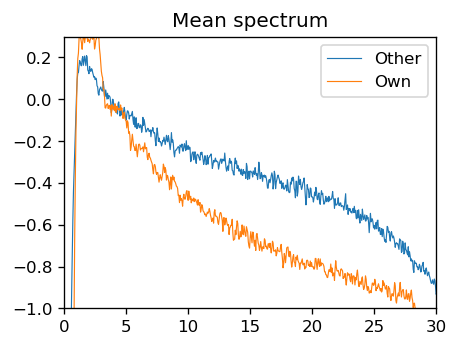

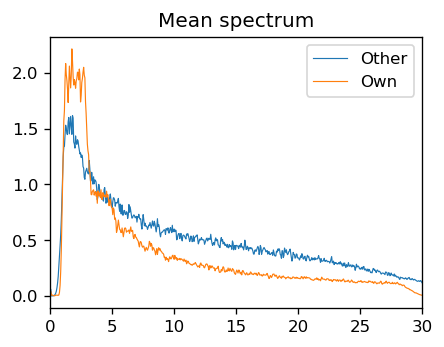

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.plot(freq, np.log10(mean_power), linewidth=0.7, label="Other")
ax.plot(freq, np.log10(mean_power_own), linewidth=0.7, label="Own")
ax.set_xlim([0, 30])
ax.set_ylim([-1, 0.3])
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.plot(freq, mean_power, linewidth=0.7, label="Other")
ax.plot(freq, mean_power_own, linewidth=0.7, label="Own")
ax.set_xlim([0, 30])
ax.legend()
plt.show()

# Original wavelet

In [ ]:
fs = 200
upper_freq = 13
lower_freq = 2
n_scales = 4
size_factor = 1.0
beta = 0.5

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
one_side = size_factor * int(scales[-1] * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    norm_constant = np.sqrt(np.pi * beta) * scale * fs / 2.0
    exp_term = np.exp(-((k_array / scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz" % frequencies[i], loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

# Wavelet with expansion factor

In [ ]:
fs = 200
upper_freq = 13
lower_freq = 0.5
n_scales = 4
size_factor = 1.0
beta = 0.1201

logit_expansion_factor = 1.39  # 1.39 -> 0.8; 2.2 -> 0.9
expansion_factor = 1 / (1 + np.exp(-logit_expansion_factor))

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
largest_scale = scales[-1]
largest_scale_expanded = expansion_factor * largest_scale + (1 - expansion_factor)
one_side = size_factor * int(largest_scale_expanded * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
print("kernel size", kernel_size)
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    expanded_scale = expansion_factor * scale + (1 - expansion_factor)
    norm_constant = np.sqrt(np.pi * beta) * expanded_scale * fs / 2.0
    exp_term = np.exp(-((k_array / expanded_scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz (expansion %1.4f)" % (frequencies[i], expansion_factor), loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
fs = 200
upper_freq = 13
lower_freq = 0.5
n_scales = 4
size_factor = 1.0
beta = 0.287

logit_expansion_factor = 2.2  # 1.39 -> 0.8; 2.2 -> 0.9
expansion_factor = 1 / (1 + np.exp(-logit_expansion_factor))

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
largest_scale = scales[-1]
largest_scale_expanded = expansion_factor * largest_scale + (1 - expansion_factor)
one_side = size_factor * int(largest_scale_expanded * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
print("kernel size", kernel_size)
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    expanded_scale = expansion_factor * scale + (1 - expansion_factor)
    norm_constant = np.sqrt(np.pi * beta) * expanded_scale * fs / 2.0
    exp_term = np.exp(-((k_array / expanded_scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz (expansion %1.4f)" % (frequencies[i], expansion_factor), loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
def beta_from_cycles(n, q, frec):
    s = 1 / frec
    main_term = n ** 2 / 18
    q_adjust = (s / (s * q +1 - q)) ** 2
    return main_term * q_adjust

In [ ]:
beta = beta_from_cycles(n=5, q=0.9, frec=13)
print("Beta %1.4f" % beta)

In [ ]:
def logit_from_proba(p):
    l = np.log(p / (1 - p))
    return l

In [ ]:
logit_from_proba(0.98)

In [ ]:
5/15

In [ ]:
def cycles_from_beta(beta, q, frec):
    s = 1 / frec
    s_expanded = s * q + (1 - q)
    cycles = 2 * s_expanded * np.sqrt(4.5 * beta) * frec
    return cycles

In [ ]:
cycles_from_beta(0.2870, 0.9, 3)